**STOCK PORTFOLIO OPTIMIZATION USING PYTHON**
1. Can do analysis with different stocks.
2. Some assumptions and attributes are taken to complete the portfolio. Can change them according to personal requirements and market conditions.

     pcost       dcost       gap    pres   dres
 0:  9.4962e-05 -8.7501e+00  9e+00  2e-16  3e-16
 1:  9.4961e-05 -8.7706e-02  9e-02  2e-16  1e-15
 2:  9.4845e-05 -1.0800e-03  1e-03  2e-16  2e-17
 3:  8.9953e-05 -7.2138e-05  2e-04  1e-16  3e-18
 4:  8.5902e-05  7.8405e-05  7e-06  2e-16  7e-20
 5:  8.5602e-05  8.5312e-05  3e-07  2e-16  6e-20
 6:  8.5587e-05  8.5577e-05  1e-08  2e-16  7e-20
Optimal solution found.
Optimal Portfolio Composition:
       Stock   Weight      Price
/content/COL 0.215210  15.830000
/content/CSL 0.030468 307.000000
/content/FPH 0.278644  29.780001
/content/JBH 0.127899  30.990000
/content/RMD 0.134699  23.639999
/content/TPM 0.068244   7.309836
/content/SAR 0.079637   3.760000
/content/FMG 0.065201  10.350000

Expected Return: 0.11%
Volatility (Risk): 1.31%
Sharpe Ratio: -1.4437
Maximum Single-Asset Allocation: 27.86%
Total Investment: $29.68


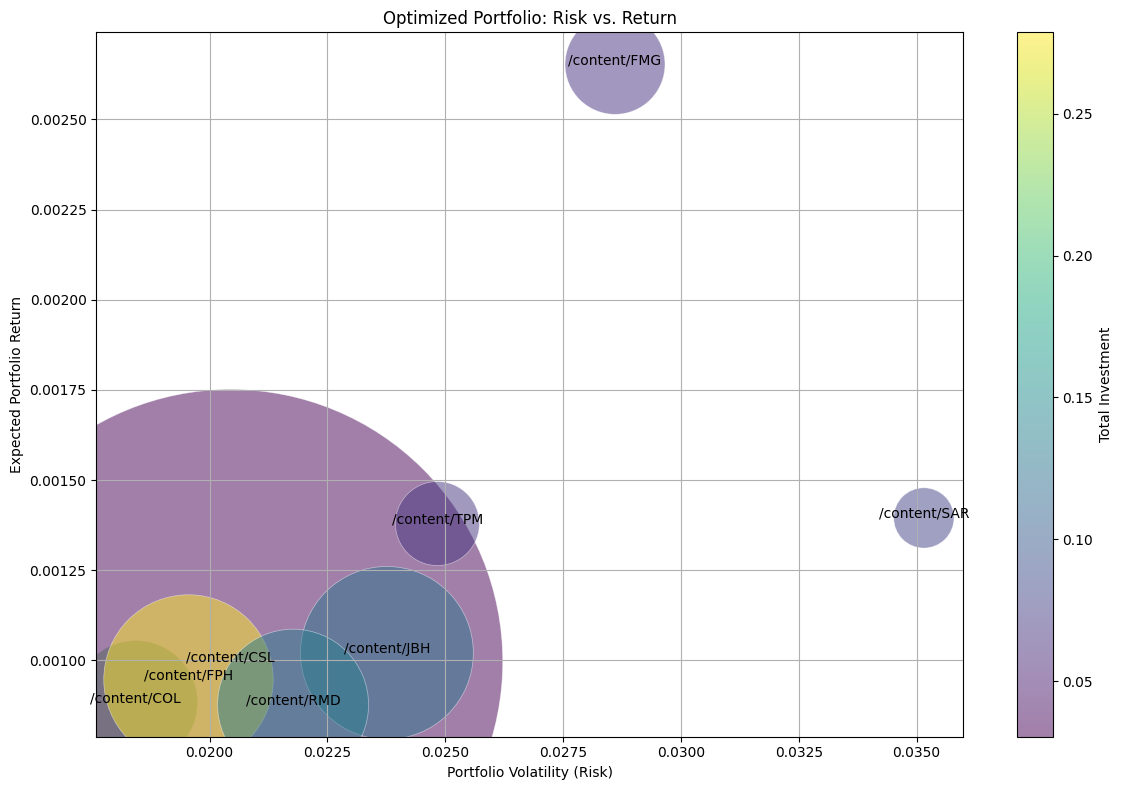

In [ ]:
import pandas as pd
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt

# Step 1: Load Historical Stock Data
def load_stock_data(files):
    stock_data = {}
    for file in files:
        stock_name = file.split('.')[0]  # Assuming filenames are like 'FMG.csv'
        df = pd.read_csv(file)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        stock_data[stock_name] = df
    return stock_data

#CSV files '/content/SAR.csv' '/content/FMG.csv'
files = ['/content/COL.csv', '/content/CSL.csv', '/content/FPH.csv', '/content/JBH.csv', '/content/RMD.csv',  '/content/TPM.csv','/content/SAR.csv', '/content/FMG.csv']
# Load historical stock data
stock_data = load_stock_data(files)

# Step 2: Calculate Expected Returns
def calculate_expected_returns(stock_data):
    returns = {}
    for stock, df in stock_data.items():
        df['Daily Return'] = df['Adj Close'].pct_change()
        avg_return = df['Daily Return'].mean()
        returns[stock] = avg_return
    return returns

# Calculate expected returns
expected_returns = calculate_expected_returns(stock_data)

# Step 3: Calculate Covariance Matrix and Daily Returns
def calculate_covariance_matrix(stock_data):
    closing_prices = pd.DataFrame({stock: data['Adj Close'] for stock, data in stock_data.items()})
    daily_returns = closing_prices.pct_change().dropna()
    covariance_matrix = daily_returns.cov()
    return covariance_matrix, daily_returns

# Calculate covariance matrix and daily returns
covariance_matrix, daily_returns = calculate_covariance_matrix(stock_data)

# Step 4: Portfolio Optimization (Mean-Variance Optimization)
def optimize_portfolio(expected_returns, covariance_matrix, daily_returns, stock_data):
    num_assets = len(expected_returns)

    # Extract current prices from stock_data
    current_prices = {stock: data['Adj Close'][-1] for stock, data in stock_data.items()}

    # Convert expected returns and covariance matrix to matrices
    P = matrix(covariance_matrix.values)
    q = matrix(np.zeros(num_assets))
    G = matrix(np.vstack((-np.eye(num_assets), np.eye(num_assets))))
    h = matrix(np.hstack((np.zeros(num_assets), np.ones(num_assets))))
    A = matrix(1.0, (1, num_assets))
    b = matrix(1.0)


    sol = solvers.qp(P, q, G, h, A, b)

    # Extract optimal portfolio
    optimal_weights = np.array(sol['x']).flatten()
    optimal_portfolio = pd.DataFrame({'Stock': list(expected_returns.keys()), 'Weight': optimal_weights})
    optimal_portfolio = optimal_portfolio[optimal_portfolio['Weight'] > 1e-5]  # Filter out negligible weights

    # Add current prices to the optimal portfolio DataFrame
    optimal_portfolio['Price'] = optimal_portfolio['Stock'].map(current_prices)

    # Calculate expected return and volatility of the optimal portfolio
    expected_return = np.dot(optimal_weights, list(expected_returns.values()))
    volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(covariance_matrix, optimal_weights)))

    # Calculate total investment (from historical data)
    total_investment = 0.0
    for stock in optimal_portfolio['Stock']:
        weight = optimal_portfolio[optimal_portfolio['Stock'] == stock]['Weight'].values[0]
        price = current_prices[stock]
        total_investment += weight * price

    # Calculate Sharpe Ratio
    risk_free_rate = 0.02 # Example risk-free rate (can change according to market conditions and requirements)
    sharpe_ratio = (expected_return - risk_free_rate) / volatility

    # Calculate Maximum Single-Asset Allocation
    max_single_asset_allocation = optimal_portfolio['Weight'].max()

    return optimal_portfolio, expected_return, volatility, sharpe_ratio, max_single_asset_allocation, total_investment

# Perform portfolio optimization
optimal_portfolio, expected_return, volatility, sharpe_ratio, max_single_asset_allocation, total_investment = optimize_portfolio(expected_returns, covariance_matrix, daily_returns, stock_data)

# Step 5: Output Results and Visualizations
print("Optimal Portfolio Composition:")
print(optimal_portfolio.to_string(index=False))
print("\nExpected Return: {:.2%}".format(expected_return))
print("Volatility (Risk): {:.2%}".format(volatility))
print("Sharpe Ratio: {:.4f}".format(sharpe_ratio))
print("Maximum Single-Asset Allocation: {:.2%}".format(max_single_asset_allocation))
print("Total Investment: ${:,.2f}".format(total_investment))

# Visualization: Scatter Plot of Expected Portfolio Return vs. Portfolio Volatility

# Extract volatility and expected return for each stock
volatility = [np.sqrt(covariance_matrix.loc[s, s]) for s in optimal_portfolio['Stock']]
expected_return = [expected_returns[s] for s in optimal_portfolio['Stock']]

# Calculate bubble sizes based on total investment
bubble_sizes = [optimal_portfolio[optimal_portfolio['Stock'] == stock]['Price'].values[0] * 500 for stock in optimal_portfolio['Stock']]

plt.figure(figsize=(12, 8))
plt.scatter(volatility, expected_return, s=bubble_sizes, alpha=0.5, c=optimal_portfolio['Weight'], cmap='viridis', edgecolors="w", linewidth=0.5)
plt.title('Optimized Portfolio: Risk vs. Return')
plt.xlabel('Portfolio Volatility (Risk)')
plt.ylabel('Expected Portfolio Return')
plt.colorbar(label='Total Investment')
plt.grid(True)

# Annotate bubbles with stock names
for i, txt in enumerate(optimal_portfolio['Stock']):
    plt.annotate(txt, (volatility[i], expected_return[i]), fontsize=10, ha='center')

plt.tight_layout()
plt.show()